### Funciones para todos los ejercicios
Adapto las funciones para poder reutilizarlas en los diferentes ejercicios

In [2]:
import random
import matplotlib.pyplot as plt
#import seaborn as sns
#sns.set_style("darkgrid")
plt.style.use('dark_background')


# parametros
TAMANIO_POBLACION = 4
LONGITUD_CROMOSOMA = 7
TASA_MUTACION = 0.1
TASA_CRUCE = 0.92
GENERACIONES = 10
EPSILON = 0.001  # Valor pequeño para evitar división por cero en la funcion fitness
X_MIN = 0
X_MAX = 31
OBJ = 'MAX' # MAX o MIN
ELITISMO = True # True o False
SELECCION = 'ruleta' # ruleta, ranking o torneo
TAMANIO_TORNEO = 2


#  -----------------------------------------------------------------
# funcion para mapear el valor binario a un rango [X_MIN, X_MAX]
#  -----------------------------------------------------------------
def binario_a_decimal(cromosoma):
    decimal = int(cromosoma, 2)
    x = X_MIN + decimal * (X_MAX - X_MIN) / ((2 ** LONGITUD_CROMOSOMA) - 1)
    return x

#  -----------------------------------------------------------------
# Aqui en las proximas lineas se puede ver que mi funcion objetivo es
# a veces diferente de mi funcion fitness, depende del problema a resolver
#  -----------------------------------------------------------------


#  -----------------------------------------------------------------
# funcion objetivo x^2
#  -----------------------------------------------------------------
def funcion_objetivo(x):
    return x ** 2


#  -----------------------------------------------------------------
# funcion fitness o tambien llamada funcion de aptitud (1/(x^2 + epsilon))
#  -----------------------------------------------------------------
def aptitud(cromosoma):
    x = binario_a_decimal(cromosoma)
    if OBJ == 'MIN':
        return 1 / (funcion_objetivo(x) + EPSILON)
    elif OBJ =='MAX':
        return x ** 2


#  -----------------------------------------------------------------
# se inicializa la poblacion
#  -----------------------------------------------------------------
def inicializar_poblacion(tamanio_poblacion, longitud_cromosoma):
    poblacion = []
    for tp in range(tamanio_poblacion):
        cromosoma = ''
        for lc in range(longitud_cromosoma):
            cromosoma = cromosoma+str(random.randint(0, 1))
        poblacion.append(cromosoma)
    return poblacion

#  -----------------------------------------------------------------
# seleccion por ruleta
#  -----------------------------------------------------------------
def seleccion_ruleta(poblacion, aptitud_total):
    probabilidades = []
    for individuo in poblacion:
        prob = aptitud(individuo) / aptitud_total
        probabilidades.append(prob)

    probabilidades_acumuladas = []
    suma = 0
    for prob in probabilidades:
        suma += prob
        probabilidades_acumuladas.append(suma)

    r = random.random()
    for i, acumulada in enumerate(probabilidades_acumuladas):
        if r <= acumulada:
            return poblacion[i]


#  -----------------------------------------------------------------
# seleccion por torneo
#  -----------------------------------------------------------------
def seleccion_torneo(poblacion, tamanio_torneo=TAMANIO_TORNEO):
    progenitores = []
    for _ in range(len(poblacion)):
        candidatos = random.sample(poblacion, tamanio_torneo)
        progenitor = max(candidatos, key=aptitud)  # se selecciona el mejor individuo del torneo
        progenitores.append(progenitor)
    return progenitores


# -----------------------------------------------------------------
# seleccion por ranking lineal
# -----------------------------------------------------------------
def seleccion_ranking(poblacion):
    # se calcula la aptitud de cada individuo
    aptitudes = []
    for individuo in poblacion:
        aptitudes.append(aptitud(individuo))

    # se ordena la poblacion por aptitud (mayor aptitud es mejor)
    # x es la tupla de zip, de la cual se toma el segundo elemento (x[1]) para
    # ser ordenada la tupla por ese elemento, en este caso por aptitud
    poblacion_ordenada = sorted(zip(poblacion, aptitudes), key=lambda x: x[1])

    # se calcula probabilidades segun el ranking lineal
    N = len(poblacion)
    s = 1.7  # Factor de seleccion comunmente usado
    probabilidades = []
    for i in range(N):
        prob = (2 - s) / N + (2 * i * (s - 1)) / (N * (N - 1))
        probabilidades.append(prob)

    # se selecciona un progenitor basado en las probabilidades
    r = random.random()
    suma = 0
    for i in range(N):
        suma = suma + probabilidades[i]
        if r <= suma:
            return poblacion_ordenada[i][0]  # se retornar el cromosomas

#  -----------------------------------------------------------------
# cruce monopunto con probabilidad de cruza pc = TASA_CRUCE
#  -----------------------------------------------------------------
def cruce_mono_punto(progenitor1, progenitor2, tasa_cruce):
    if random.random() < tasa_cruce:
        punto_cruce = random.randint(1, len(progenitor1) - 1)
        descendiente1 = progenitor1[:punto_cruce] + progenitor2[punto_cruce:]
        descendiente2 = progenitor2[:punto_cruce] + progenitor1[punto_cruce:]
    else:
        descendiente1, descendiente2 = progenitor1, progenitor2
    return descendiente1, descendiente2


#  -----------------------------------------------------------------
# mutacion
#  -----------------------------------------------------------------
def mutacion(cromosoma, tasa_mutacion):
    cromosoma_mutado = ""
    for bit in cromosoma:
        if random.random() < tasa_mutacion:
            cromosoma_mutado = cromosoma_mutado + str(int(not int(bit)))
        else:
            cromosoma_mutado = cromosoma_mutado + bit
    return cromosoma_mutado


In [3]:
#  -----------------------------------------------------------------
# aplicación de operadores geneticos
#  -----------------------------------------------------------------
def algoritmo_genetico(tamanio_poblacion, longitud_cromosoma, tasa_mutacion, tasa_cruce, generaciones, seleccion, elitismo, imprimir=True):
    poblacion = inicializar_poblacion(tamanio_poblacion, longitud_cromosoma)
    mejor_funcion_objetivo_generaciones = []  # Lista para almacenar la aptitud del mejor individuo y grficar luego

    for generacion in range(generaciones):
        if imprimir==True: print("Generación:", generacion + 1)

        # se calcula aptitud total para luego
        aptitud_total = sum(aptitud(cromosoma) for cromosoma in poblacion)

        if imprimir==True: print("Aptitud total:", aptitud_total)

        #  -----------------------------------------------------------------
        
        if seleccion == 'ruleta':
            # seleccion de progenitores con el metodo ruleta
            progenitores = []
            for _ in range(tamanio_poblacion):
                progenitores.append(seleccion_ruleta(poblacion, aptitud_total))
        
        elif seleccion == 'torneo':            
            # seleccion de progenitores con el metodo de torneo
            progenitores = seleccion_torneo(poblacion)
        
        elif seleccion == 'ranking':            
            # seleccion de progenitores con el metodo de ranking lineal
            progenitores = []
            for _ in range(tamanio_poblacion):
                progenitores.append(seleccion_ranking(poblacion))
        #  -----------------------------------------------------------------
        # Cruce
        descendientes = []
        for i in range(0, tamanio_poblacion, 2):
            descendiente1, descendiente2 = cruce_mono_punto(progenitores[i], progenitores[i + 1], tasa_cruce)
            descendientes.extend([descendiente1, descendiente2])

        #  -----------------------------------------------------------------
        # Mutacion
        descendientes_mutados = []
        for descendiente in descendientes:
            descendientes_mutados.append(mutacion(descendiente, tasa_mutacion))

        if elitismo:
            # Aquí se aplica elitismo
            # Se reemplazan los peores cromosomas con los mejores progenitores
            poblacion.sort(key=aptitud)  # se ordena la poblacion por aptitud en forma ascendente
            # se ordena los descendientes por aptitud en forma descendente
            descendientes_mutados.sort(key=aptitud, reverse=True)
            for i in range(len(descendientes_mutados)):
                if aptitud(descendientes_mutados[i]) > aptitud(poblacion[i]):
                    poblacion[i] = descendientes_mutados[i]                

        else: # si no hay elitismo, todos los descendientes pasan a ser la nueva poblacion
            poblacion = descendientes_mutados

        # Mostrar el mejor individuo de la generacion
        mejor_individuo = max(poblacion, key=aptitud)  # Buscar el maximo para la aptitud
        mejor_funcion_objetivo_generaciones.append(funcion_objetivo(binario_a_decimal(mejor_individuo)))

        if imprimir == True:
            print("mi", mejor_individuo)
            print("Mejor individuo:", binario_a_decimal(mejor_individuo), "Aptitud:", aptitud(mejor_individuo))
            print("_________________________________________________________________________________")

    if imprimir ==True:
        # Graficar la evolución de la aptitud
        plt.plot(range(1, generaciones + 1), mejor_funcion_objetivo_generaciones, marker='o')
        plt.xlabel('Generación')
        plt.ylabel('Valor de la Función Objetivo')
        plt.title('Curva de Convergencia del Algoritmo Genético')
        plt.grid(True)
        plt.show()
    return max(poblacion, key=aptitud)  # se retorna el mejor individuo


### Ejercicio 1

_________________________________________________________________________________

Generación: 1
Aptitud total: 2723.8561597123194
mi 1110101
Mejor individuo: 28.559055118110237 Aptitud: 815.6196292392585
_________________________________________________________________________________
Generación: 2
Aptitud total: 3152.8474176948357
mi 1110101
Mejor individuo: 28.559055118110237 Aptitud: 815.6196292392585
_________________________________________________________________________________
Generación: 3
Aptitud total: 3207.662967325935
mi 1110101
Mejor individuo: 28.559055118110237 Aptitud: 815.6196292392585
_________________________________________________________________________________
Generación: 4
Aptitud total: 3262.478516957034
mi 1110111
Mejor individuo: 29.04724409448819 Aptitud: 843.742389484779
_________________________________________________________________________________
Generación: 5
Aptitud total: 3290.6012772025547
mi 1110111
Mejor individuo: 29.04724409448819 Aptitud: 84

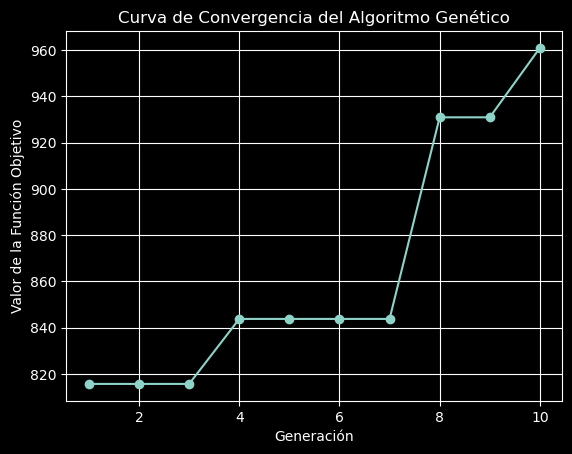

Mejor solución: 31.0 Aptitud: 961.0


In [4]:
# parametros
TAMANIO_POBLACION = 4
LONGITUD_CROMOSOMA = 7
TASA_MUTACION = 0.1
TASA_CRUCE = 0.92
GENERACIONES = 10
EPSILON = 0.001  # Valor pequeño para evitar división por cero en la funcion fitness
X_MIN = 0
X_MAX = 31
OBJ = 'MAX' # MAX o MIN
ELITISMO = True # True o False
SELECCION = 'ruleta' # ruleta, ranking o torneo
TAMANIO_TORNEO = 2

#  -----------------------------------------------------------------
# ejecucion principal del algoritmo genetico
#  -----------------------------------------------------------------
print("_________________________________________________________________________________")
print()
mejor_solucion = algoritmo_genetico(TAMANIO_POBLACION, LONGITUD_CROMOSOMA, TASA_MUTACION, TASA_CRUCE, GENERACIONES, SELECCION, ELITISMO)
print("Mejor solución:", binario_a_decimal(mejor_solucion), "Aptitud:", aptitud(mejor_solucion))

In [5]:
# aca voy a generar la tabla con 10 lanzamientos

soluciones = []
for i in range(10):
    soluciones.append(algoritmo_genetico(TAMANIO_POBLACION, LONGITUD_CROMOSOMA,
                            TASA_MUTACION, TASA_CRUCE, GENERACIONES,SELECCION,
                            ELITISMO, False))
print('Soluciones')
for i, sol in enumerate(soluciones):
    print('{0:.3f}'.format(binario_a_decimal(sol)))

Soluciones
28.803
31.000
31.000
30.756
31.000
31.000
31.000
31.000
31.000
31.000


### Ejercicio 2

#### 2.1_Selecccion Ruleta

_________________________________________________________________________________

Generación: 1
Aptitud total: 0.03338760797073017
mi 1001101111
Mejor individuo: 6.757575757575758 Aptitud: 0.021898211362541498
_________________________________________________________________________________
Generación: 2
Aptitud total: 0.07369245497887125
mi 1001101001
Mejor individuo: 6.393939393939391 Aptitud: 0.02445976872289171
_________________________________________________________________________________
Generación: 3
Aptitud total: 0.0901544028105162
mi 1000101111
Mejor individuo: 2.8787878787878753 Aptitud: 0.12065026170249403
_________________________________________________________________________________
Generación: 4
Aptitud total: 0.18890645315046872
mi 1000101111
Mejor individuo: 2.8787878787878753 Aptitud: 0.12065026170249403
_________________________________________________________________________________
Generación: 5
Aptitud total: 0.19450679117000655
mi 1000101011
Mejor individuo:

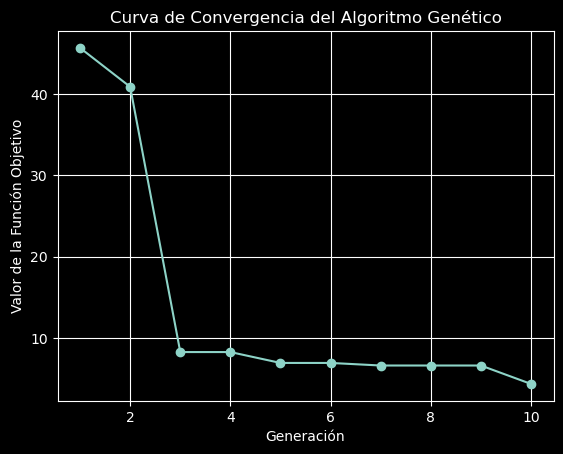

Mejor solución: 2.0909090909090935 Aptitud: 0.22868115232621591


In [173]:
# parametros
TAMANIO_POBLACION = 4
LONGITUD_CROMOSOMA = 10
TASA_MUTACION = 0.09
TASA_CRUCE = 0.85
GENERACIONES = 10
EPSILON = 0.001  # Valor pequeño para evitar división por cero en la funcion fitness
X_MIN = -31
X_MAX = 31
OBJ = 'MIN' # MAX o MIN
ELITISMO = True # True o False
SELECCION = 'ruleta' # ruleta, ranking o torneo


#  -----------------------------------------------------------------
# ejecucion principal del algoritmo genetico
#  -----------------------------------------------------------------
print("_________________________________________________________________________________")
print()
mejor_solucion = algoritmo_genetico(TAMANIO_POBLACION, LONGITUD_CROMOSOMA, TASA_MUTACION, TASA_CRUCE, GENERACIONES, SELECCION, ELITISMO)
print("Mejor solución:", binario_a_decimal(mejor_solucion), "Aptitud:", aptitud(mejor_solucion))

In [7]:
# aca voy a generar la tabla con 10 lanzamientos

solucionesRuleta = []
for i in range(30):
    solucionesRuleta.append(algoritmo_genetico(TAMANIO_POBLACION, LONGITUD_CROMOSOMA,
                            TASA_MUTACION, TASA_CRUCE, GENERACIONES,SELECCION,
                            ELITISMO, False))
print('SolucionesRuleta')
for i, sol in enumerate(solucionesRuleta):
    print('{0:.3f}'.format(binario_a_decimal(sol)))

SolucionesRuleta
4.030
0.576
-0.152
2.455
1.303
3.909
0.394
1.000
1.061
-0.091
-0.030
-0.515
-0.030
-0.091
-0.273
0.030
0.515
0.152
0.152
0.030
0.030
0.212
-0.636
1.000
-0.030
-0.030
0.030
0.273
-0.273
-0.030


#### 2.2_Seleccion Torneo

_________________________________________________________________________________

Generación: 1
Aptitud total: 0.020760843266493086
mi 1010011011
Mejor individuo: 9.424242424242422 Aptitud: 0.011259062032872351
_________________________________________________________________________________
Generación: 2
Aptitud total: 0.038294319679619
mi 1000111011
Mejor individuo: 3.606060606060609 Aptitud: 0.0768954354121061
_________________________________________________________________________________
Generación: 3
Aptitud total: 0.09188114705285805
mi 1000110011
Mejor individuo: 3.1212121212121247 Aptitud: 0.1026381588316552
_________________________________________________________________________________
Generación: 4
Aptitud total: 0.11343890376207429
mi 1000110011
Mejor individuo: 3.1212121212121247 Aptitud: 0.1026381588316552
_________________________________________________________________________________
Generación: 5
Aptitud total: 0.3125061178970987
mi 1000110011
Mejor individuo: 3.1

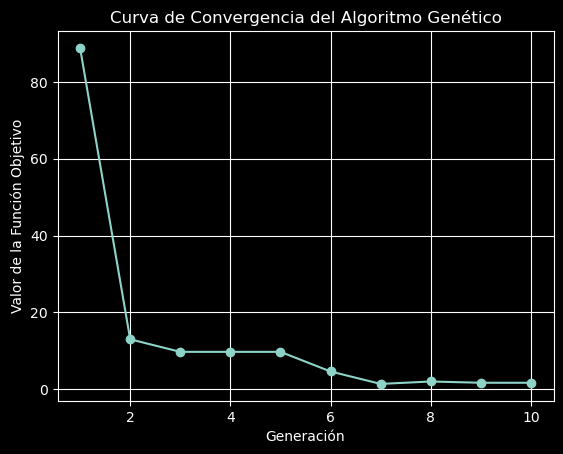

Mejor solución: 1.3030303030303045 Aptitud: 0.5886203312381175


In [8]:
# parametros
TAMANIO_POBLACION = 4
LONGITUD_CROMOSOMA = 10
TASA_MUTACION = 0.09
TASA_CRUCE = 0.85
GENERACIONES = 10
EPSILON = 0.001  # Valor pequeño para evitar división por cero en la funcion fitness
X_MIN = -31
X_MAX = 31
OBJ = 'MIN' # MAX o MIN
ELITISMO = False # True o False
SELECCION = 'torneo' # ruleta, ranking o torneo

#  -----------------------------------------------------------------
# ejecucion principal del algoritmo genetico
#  -----------------------------------------------------------------
print("_________________________________________________________________________________")
print()
mejor_solucion = algoritmo_genetico(TAMANIO_POBLACION, LONGITUD_CROMOSOMA, TASA_MUTACION, TASA_CRUCE, GENERACIONES, SELECCION, ELITISMO)
print("Mejor solución:", binario_a_decimal(mejor_solucion), "Aptitud:", aptitud(mejor_solucion))

In [9]:
# aca voy a generar la tabla con 10 lanzamientos

solucionesTorneo = []
for i in range(30):
    solucionesTorneo.append(algoritmo_genetico(TAMANIO_POBLACION, LONGITUD_CROMOSOMA,
                            TASA_MUTACION, TASA_CRUCE, GENERACIONES,SELECCION,
                            ELITISMO, False))
print('solucionesTorneo')
for i, sol in enumerate(solucionesTorneo):
    print('{0:.3f}'.format(binario_a_decimal(sol)))

solucionesTorneo
0.879
-0.152
4.273
2.879
6.576
-0.091
0.152
0.273
0.455
-8.879
-0.273
0.697
0.758
-4.333
-7.182
-1.121
0.333
-2.030
-2.394
0.576
-1.727
-0.576
-4.394
-0.394
-4.030
9.727
0.333
-0.636
2.515
8.030


#### 2.3_Seleccion Ranking

_________________________________________________________________________________

Generación: 1
Aptitud total: 13.428114315481023
mi 0111111011
Mejor individuo: -0.2727272727272734 Aptitud: 13.26608924460031
_________________________________________________________________________________
Generación: 2
Aptitud total: 14.756469959094778
mi 0111111111
Mejor individuo: -0.030303030303031164 Aptitud: 521.3020584011347
_________________________________________________________________________________
Generación: 3
Aptitud total: 577.3088788758674
mi 0111111111
Mejor individuo: -0.030303030303031164 Aptitud: 521.3020584011347
_________________________________________________________________________________
Generación: 4
Aptitud total: 578.3642498785492
mi 0111111111
Mejor individuo: -0.030303030303031164 Aptitud: 521.3020584011347
_________________________________________________________________________________
Generación: 5
Aptitud total: 1126.0875772645322
mi 0111111111
Mejor individuo: -0

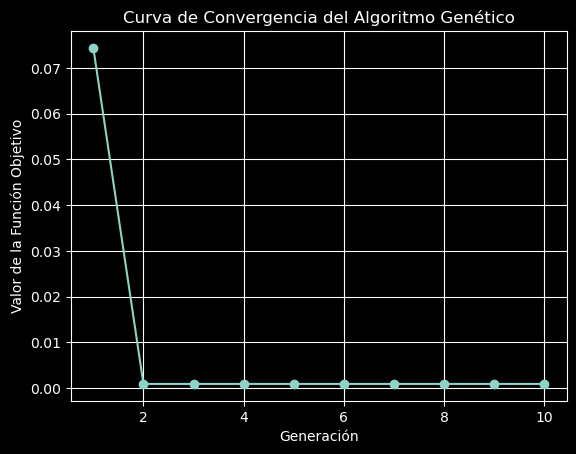

Mejor solución: -0.030303030303031164 Aptitud: 521.3020584011347


In [10]:
# parametros
TAMANIO_POBLACION = 4
LONGITUD_CROMOSOMA = 10
TASA_MUTACION = 0.09
TASA_CRUCE = 0.85
GENERACIONES = 10
EPSILON = 0.001  # Valor pequeño para evitar división por cero en la funcion fitness
X_MIN = -31
X_MAX = 31
OBJ = 'MIN' # MAX o MIN
ELITISMO = True # True o False
SELECCION = 'ranking' # ruleta, ranking o torneo

#  -----------------------------------------------------------------
# ejecucion principal del algoritmo genetico
#  -----------------------------------------------------------------
print("_________________________________________________________________________________")
print()
mejor_solucion = algoritmo_genetico(TAMANIO_POBLACION, LONGITUD_CROMOSOMA, TASA_MUTACION, TASA_CRUCE, GENERACIONES, SELECCION, ELITISMO)
print("Mejor solución:", binario_a_decimal(mejor_solucion), "Aptitud:", aptitud(mejor_solucion))

In [11]:
# aca voy a generar la tabla con 10 lanzamientos

solucionesRanking = []
for i in range(30):
    solucionesRanking.append(algoritmo_genetico(TAMANIO_POBLACION, LONGITUD_CROMOSOMA,
                            TASA_MUTACION, TASA_CRUCE, GENERACIONES,SELECCION,
                            ELITISMO, False))
print('solucionesRanking')
for i, sol in enumerate(solucionesRanking):
    print('{0:.3f}'.format(binario_a_decimal(sol)))

solucionesRanking
0.030
2.030
0.273
0.273
1.061
-0.030
-0.273
-1.000
0.030
-0.152
0.515
0.091
0.030
0.273
0.212
-0.030
1.061
-1.970
-0.515
-0.030
0.152
0.273
0.030
0.030
-0.152
-0.152
-0.152
-0.091
-1.061
-1.000


In [12]:
import numpy as np
rank = np.array([binario_a_decimal(i) for i in solucionesRanking])
rule = np.array([binario_a_decimal(i) for i in solucionesRuleta])
torn = np.array([binario_a_decimal(i) for i in solucionesTorneo])

In [13]:
tabla = np.array(
    [[rank.min(), rank.mean(), rank.max(), rank.std()],
    [rule.min(), rule.mean(), rule.max(), rule.std()],
    [torn.min(), torn.mean(), torn.max(), torn.std()]])

print(tabla)

[[-1.96969697e+00 -8.08080808e-03  2.03030303e+00  6.94282626e-01]
 [-6.36363636e-01  4.98989899e-01  4.03030303e+00  1.10583873e+00]
 [-8.87878788e+00  8.08080808e-03  9.72727273e+00  3.81983236e+00]]


#### d. cambiar parametros y probar

_________________________________________________________________________________

Generación: 1
Aptitud total: 0.17735727497267664
mi 1000101000
Mejor individuo: 2.4545454545454533 Aptitud: 0.16595325055786367
_________________________________________________________________________________
Generación: 2
Aptitud total: 1.038540481907382
mi 1000001010
Mejor individuo: 0.6363636363636367 Aptitud: 2.4633049001445384
_________________________________________________________________________________
Generación: 3
Aptitud total: 7.657475047132234
mi 1000000011
Mejor individuo: 0.21212121212121104 Aptitud: 21.741300485136673
_________________________________________________________________________________
Generación: 4
Aptitud total: 37.902188652693056
mi 1000000011
Mejor individuo: 0.21212121212121104 Aptitud: 21.741300485136673
_________________________________________________________________________________
Generación: 5
Aptitud total: 120.61409402794426
mi 1000000001
Mejor individuo: 0.09

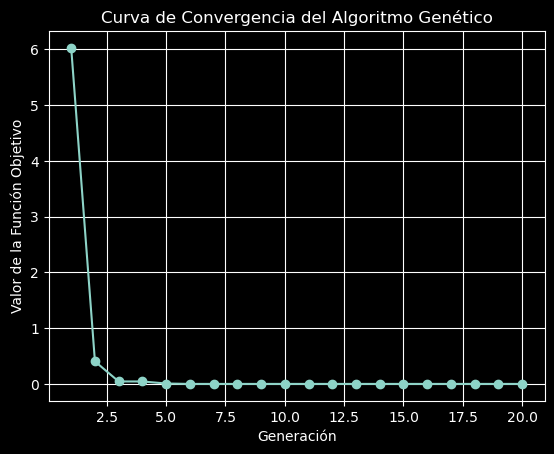

Mejor solución: 0.030303030303031164 Aptitud: 521.3020584011347


In [147]:
# parametros
TAMANIO_POBLACION = 10
LONGITUD_CROMOSOMA = 10
TASA_MUTACION = 0.09
TASA_CRUCE = 0.85
GENERACIONES = 20
EPSILON = 0.001  # Valor pequeño para evitar división por cero en la funcion fitness
X_MIN = -31
X_MAX = 31
OBJ = 'MIN' # MAX o MIN
ELITISMO = True # True o False
SELECCION = 'ruleta' # ruleta, ranking o torneo

#  -----------------------------------------------------------------
# ejecucion principal del algoritmo genetico
#  -----------------------------------------------------------------
print("_________________________________________________________________________________")
print()
mejor_solucion = algoritmo_genetico(TAMANIO_POBLACION, LONGITUD_CROMOSOMA, TASA_MUTACION, TASA_CRUCE, GENERACIONES, SELECCION, ELITISMO)
print("Mejor solución:", binario_a_decimal(mejor_solucion), "Aptitud:", aptitud(mejor_solucion))

_________________________________________________________________________________

Generación: 1
Aptitud total: 4.594734372870368
mi 0111110111
Mejor individuo: -0.5151515151515156 Aptitud: 3.7540203179024307
_________________________________________________________________________________
Generación: 2
Aptitud total: 7.549835997419996
mi 0111110111
Mejor individuo: -0.5151515151515156 Aptitud: 3.7540203179024307
_________________________________________________________________________________
Generación: 3
Aptitud total: 20.292979562944836
mi 0111111111
Mejor individuo: -0.030303030303031164 Aptitud: 521.3020584011347
_________________________________________________________________________________
Generación: 4
Aptitud total: 556.1509081781426
mi 0111111111
Mejor individuo: -0.030303030303031164 Aptitud: 521.3020584011347
_________________________________________________________________________________
Generación: 5
Aptitud total: 568.3114872268842
mi 0111111111
Mejor individuo: -0.0

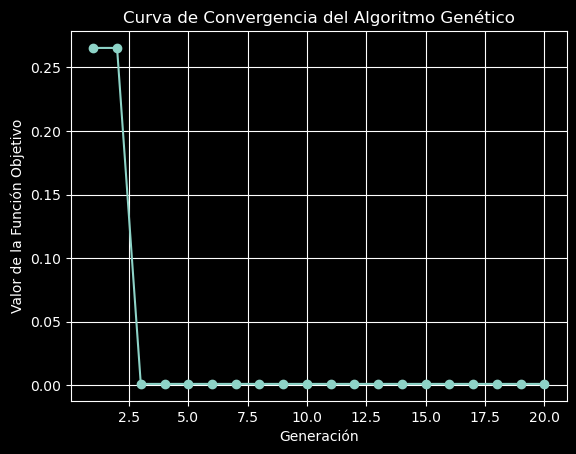

Mejor solución: -0.030303030303031164 Aptitud: 521.3020584011347


In [146]:
# parametros
TAMANIO_POBLACION = 10
LONGITUD_CROMOSOMA = 10
TASA_MUTACION = 0.09
TASA_CRUCE = 0.85
GENERACIONES = 20
EPSILON = 0.001  # Valor pequeño para evitar división por cero en la funcion fitness
X_MIN = -31
X_MAX = 31
OBJ = 'MIN' # MAX o MIN
ELITISMO = True # True o False
SELECCION = 'ranking' # ruleta, ranking o torneo

#  -----------------------------------------------------------------
# ejecucion principal del algoritmo genetico
#  -----------------------------------------------------------------
print("_________________________________________________________________________________")
print()
mejor_solucion = algoritmo_genetico(TAMANIO_POBLACION, LONGITUD_CROMOSOMA, TASA_MUTACION, TASA_CRUCE, GENERACIONES, SELECCION, ELITISMO)
print("Mejor solución:", binario_a_decimal(mejor_solucion), "Aptitud:", aptitud(mejor_solucion))

_________________________________________________________________________________

Generación: 1
Aptitud total: 7.599762488712523
mi 0111111110
Mejor individuo: -0.09090909090908994 Aptitud: 107.93933987511356
_________________________________________________________________________________
Generación: 2
Aptitud total: 108.74483524648065
mi 0111111100
Mejor individuo: -0.21212121212121104 Aptitud: 21.741300485136673
_________________________________________________________________________________
Generación: 3
Aptitud total: 23.885719861163697
mi 0111110100
Mejor individuo: -0.6969696969696955 Aptitud: 2.0543720016827454
_________________________________________________________________________________
Generación: 4
Aptitud total: 6.052679331776695
mi 0111110100
Mejor individuo: -0.6969696969696955 Aptitud: 2.0543720016827454
_________________________________________________________________________________
Generación: 5
Aptitud total: 5.744484329651233
mi 1000001100
Mejor individuo: 0.7

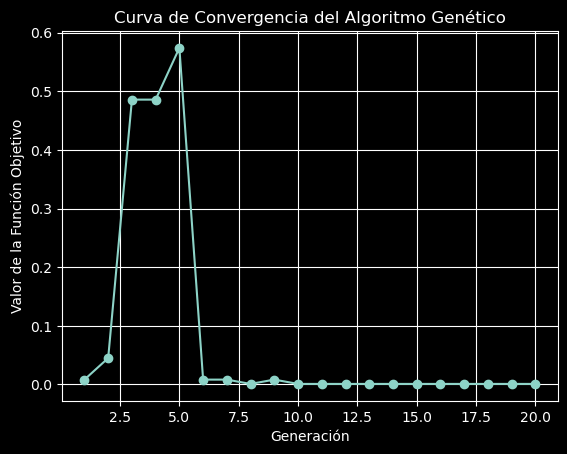

Mejor solución: 0.030303030303031164 Aptitud: 521.3020584011347


In [166]:
# parametros
TAMANIO_POBLACION = 20
LONGITUD_CROMOSOMA = 10
TASA_MUTACION = 0.07
TASA_CRUCE = 0.85
GENERACIONES = 20
EPSILON = 0.001  # Valor pequeño para evitar división por cero en la funcion fitness
X_MIN = -31
X_MAX = 31
OBJ = 'MIN' # MAX o MIN
ELITISMO = False # True o False
SELECCION = 'torneo' # ruleta, ranking o torneo
TAMANIO_TORNEO = 2

#  -----------------------------------------------------------------
# ejecucion principal del algoritmo genetico
#  -----------------------------------------------------------------
print("_________________________________________________________________________________")
print()
mejor_solucion = algoritmo_genetico(TAMANIO_POBLACION, LONGITUD_CROMOSOMA, TASA_MUTACION, TASA_CRUCE, GENERACIONES, SELECCION, ELITISMO)
print("Mejor solución:", binario_a_decimal(mejor_solucion), "Aptitud:", aptitud(mejor_solucion))